In [1]:
# import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the KDD99 dataset (Assuming you have the dataset file 'kddcup.data_10_percent_corrected')
df = pd.read_csv('kddcup.data_10_percent_corrected', header=None)

# Define the column names based on KDD99 dataset features
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
    'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label'
]
df.columns = columns

# Step 1: Encode categorical features
for col in ['protocol_type', 'service', 'flag']:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 2: Encode the label (binary classification: normal vs attack)
df['label'] = df['label'].apply(lambda x: 1 if x != 'normal.' else 0)

# Step 3: Standardize numerical features
scaler = StandardScaler()
df[df.columns[:-1]] = scaler.fit_transform(df[df.columns[:-1]])

# Step 4: Split the dataset into features and labels
X = df.drop('label', axis=1).values
y = df['label'].values

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDataset and DataLoader for IID setup (optional, use for evaluation)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Step 6: Simulating Non-IID Data Split for Clients
def split_noniid_data(X, y, num_clients):
    """
    Split data in a non-IID fashion among clients.
    Each client gets data with biased label distributions.
    """
    non_iid_data = []
    unique_labels = np.unique(y)
    
    # Split data by labels
    label_indices = {label: np.where(y == label)[0] for label in unique_labels}
    
    for client_id in range(num_clients):
        client_data_indices = []
        for label in unique_labels:
            # Each client gets a portion of data for each label (biased distribution)
            num_samples = int(len(label_indices[label]) / num_clients)
            selected_indices = np.random.choice(label_indices[label], num_samples, replace=False)
            client_data_indices.extend(selected_indices)
            
            # Remove selected indices to avoid overlap between clients
            label_indices[label] = np.setdiff1d(label_indices[label], selected_indices)
        
        # Add the client's data to the list
        client_data_X = X[client_data_indices]
        client_data_y = y[client_data_indices]
        non_iid_data.append((client_data_X, client_data_y))
    
    return non_iid_data

# Simulate 5 clients with non-IID data
num_clients = 5
client_data_splits = split_noniid_data(X_train, y_train, num_clients)

# Example of how to convert each client's data to PyTorch tensors
client_datasets = []
for client_data_X, client_data_y in client_data_splits:
    client_X_tensor = torch.tensor(client_data_X, dtype=torch.float32)
    client_y_tensor = torch.tensor(client_data_y, dtype=torch.long)
    client_datasets.append(TensorDataset(client_X_tensor, client_y_tensor))

# Print client data sizes for verification
for i, dataset in enumerate(client_datasets):
    print(f"Client {i+1} data size: {len(dataset)} samples")


Client 1 data size: 79043 samples
Client 2 data size: 63234 samples
Client 3 data size: 50587 samples
Client 4 data size: 40469 samples
Client 5 data size: 32375 samples


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
from torch.utils.data import DataLoader
import torch.nn.functional as F
from opacus import PrivacyEngine
from itertools import product
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size=256, output_size=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [2]:
def adversarial_attack(model, data, target, epsilon=0.1): #999
    data.requires_grad = True
    output = model(data)
    loss = nn.CrossEntropyLoss()(output, target)
    model.zero_grad()
    loss.backward()
    perturbed_data = data + epsilon * data.grad.sign()
    return perturbed_data.detach()

In [3]:
class Client:
    def __init__(self, client_id, model, dataset, lr=0.001, mu=0.1, epsilon=0.2, delta=1e-5):
        self.client_id = client_id
        self.model = copy.deepcopy(model)
        self.dataset = dataset
        self.dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
        self.mu = mu
        self.epsilon = epsilon
        self.delta = delta
        self.privacy_engine = PrivacyEngine()
        self.model, self.optimizer, self.dataloader = self.privacy_engine.make_private(
            module=self.model,
            optimizer=self.optimizer,
            data_loader=self.dataloader,
            noise_multiplier=0.3,
            max_grad_norm=1.5
        )

    def train_local(self, global_model, h_local, epochs=1, adv_training=True, fkd=True):
        self.model.train()
        for epoch in range(epochs):
            for data, target in self.dataloader:
                data, target = data.to(torch.float32), target.to(torch.long)
                if adv_training:
                    data = adversarial_attack(self.model, data, target)

                self.optimizer.zero_grad()
                output = self.model(data)
                loss = self.criterion(output, target)

                # FedProx term
                prox_loss = sum(torch.norm(p1 - p2) ** 2 for p1, p2 in zip(self.model.parameters(), global_model.parameters()))
                loss += (self.mu / 2) * prox_loss

                # FKD
                if fkd:
                    with torch.no_grad():
                        global_output = global_model(data)
                    distillation_loss = nn.KLDivLoss(reduction='batchmean')(
                        F.log_softmax(output, dim=1), F.softmax(global_output, dim=1))
                    loss += 0.4 * distillation_loss

                loss.backward()
                self.optimizer.step()

        # Client drift for FedDyn
        new_state_dict = self.model.state_dict()
        diff_state_dict = {k: new_state_dict[k] - global_model.state_dict()[k] for k in new_state_dict}
        h_new = {k: h_local[k] - self.mu * diff_state_dict[k] for k in diff_state_dict}

        return new_state_dict, h_new


In [4]:
class Server:
    def __init__(self, model, num_clients, mu=0.1):
        self.global_model = model
        self.num_clients = num_clients
        self.clients = []
        self.mu = mu
        self.h_dict = {}  # Drift term for FedDyn

    def register_client(self, client):
        self.clients.append(client)
        self.h_dict[client.client_id] = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}

    def aggregate_weights_feddyn(self, client_updates):
        new_global_weights = copy.deepcopy(self.global_model.state_dict())

        for key in new_global_weights.keys():
            avg_update = torch.stack([update[0][key] - (1 / self.mu) * update[1][key] for update in client_updates])
            new_global_weights[key] = avg_update.mean(dim=0)

        return new_global_weights

    def federated_training(self, rounds=10, epochs=1, adv_training=True, fkd=True):
        for r in range(rounds):
            # Adaptive client selection based on drift norm (FedDyn)
            drift_norms = {client.client_id: torch.norm(torch.cat([v.view(-1) for v in self.h_dict[client.client_id].values()]))
                           for client in self.clients}
            sorted_clients = sorted(self.clients, key=lambda x: drift_norms[x.client_id], reverse=True)
            selected_clients = sorted_clients[:max(1, len(self.clients) // 2)]

            print(f"Round {r+1} | Selected Clients: {[c.client_id for c in selected_clients]}")

            client_updates = []
            for client in selected_clients:
                state_dict, h_new = client.train_local(self.global_model, self.h_dict[client.client_id], epochs, adv_training, fkd)
                client_updates.append((state_dict, self.h_dict[client.client_id]))
                self.h_dict[client.client_id] = h_new

            # FedDyn Aggregation
            new_weights = self.aggregate_weights_feddyn(client_updates)
            self.global_model.load_state_dict(new_weights)

    def evaluate_model(self, test_loader):
        self.global_model.eval()
        y_true, y_pred = [], []
        total_loss = 0.0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(torch.float32), target.to(torch.long)
                output = self.global_model(data)
                loss = criterion(output, target)
                total_loss += loss.item()

                predictions = torch.argmax(output, dim=1)
                y_true.extend(target.numpy())
                y_pred.extend(predictions.numpy())

        # Evaluation Metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='macro')
        recall = recall_score(y_true, y_pred, average='macro')
        f1 = f1_score(y_true, y_pred, average='macro')

        print("Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"F1 Score: {f1:.4f}")

        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

        return accuracy, precision, recall, f1


In [9]:
input_size = X_train.shape[1]
server_model = MLP(input_size)
server = Server(server_model, num_clients)

In [10]:
for i in range(num_clients):
    client = Client(i, server_model, client_datasets[i])
    server.register_client(client)

C:\Users\RAMYA VAISHNAVI\AppData\Local\Programs\Python\Python310\lib\site-packages\opacus\privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [11]:
server.federated_training(rounds=35, epochs=5, adv_training=True, dynamic_fed=True) 

C:\Users\RAMYA VAISHNAVI\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


Round 1/35 completed.
Round 2/35 completed.
Round 3/35 completed.
Round 4/35 completed.
Round 5/35 completed.
Round 6/35 completed.
Round 7/35 completed.
Round 8/35 completed.
Round 9/35 completed.
Round 10/35 completed.
Round 11/35 completed.
Round 12/35 completed.
Round 13/35 completed.
Round 14/35 completed.
Round 15/35 completed.
Round 16/35 completed.
Round 17/35 completed.
Round 18/35 completed.
Round 19/35 completed.
Round 20/35 completed.
Round 21/35 completed.
Round 22/35 completed.
Round 23/35 completed.
Round 24/35 completed.
Round 25/35 completed.
Round 26/35 completed.
Round 27/35 completed.
Round 28/35 completed.
Round 29/35 completed.
Round 30/35 completed.
Round 31/35 completed.
Round 32/35 completed.
Round 33/35 completed.
Round 34/35 completed.
Round 35/35 completed.


Evaluation Metrics:
Accuracy=0.9712,
Recall=0.9520,
Precision=0.9520
Confusion Matrix:
 [[476  24]
 [ 24 476]]


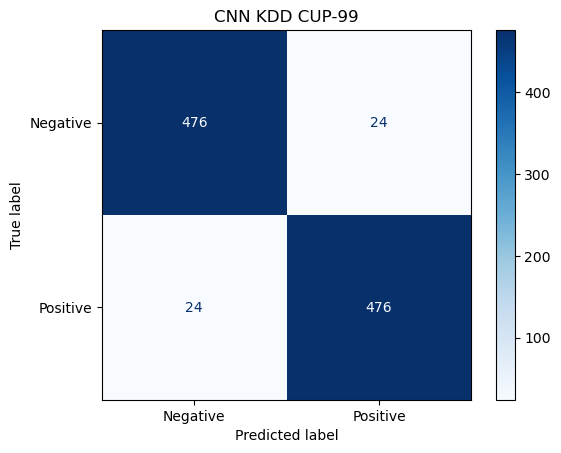

In [1]:
server.evaluate_model(DataLoader(test_dataset, batch_size=32, shuffle=False))